<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Notebook-Description" data-toc-modified-id="Notebook-Description-0.0.1">Notebook Description</a></span></li><li><span><a href="#Importing-SBML-Model" data-toc-modified-id="Importing-SBML-Model-0.0.2">Importing SBML Model</a></span><ul class="toc-item"><li><span><a href="#Construct-SciPyModel-Instance" data-toc-modified-id="Construct-SciPyModel-Instance-0.0.2.1">Construct SciPyModel Instance</a></span></li><li><span><a href="#User-File-Selection" data-toc-modified-id="User-File-Selection-0.0.2.2">User File Selection</a></span></li><li><span><a href="#Clean-SBML-File" data-toc-modified-id="Clean-SBML-File-0.0.2.3">Clean SBML File</a></span></li><li><span><a href="#Extract-MetaData" data-toc-modified-id="Extract-MetaData-0.0.2.4">Extract MetaData</a></span></li><li><span><a href="#Extract-Compartment-Data" data-toc-modified-id="Extract-Compartment-Data-0.0.2.5">Extract Compartment Data</a></span></li><li><span><a href="#Extract-Species-Data" data-toc-modified-id="Extract-Species-Data-0.0.2.6">Extract Species Data</a></span></li><li><span><a href="#Extract-Parameter-Data" data-toc-modified-id="Extract-Parameter-Data-0.0.2.7">Extract Parameter Data</a></span></li><li><span><a href="#Extract-Reaction-Data" data-toc-modified-id="Extract-Reaction-Data-0.0.2.8">Extract Reaction Data</a></span></li><li><span><a href="#Vectorize-Reaction-Declarations" data-toc-modified-id="Vectorize-Reaction-Declarations-0.0.2.9">Vectorize Reaction Declarations</a></span></li></ul></li><li><span><a href="#Constructing-Model-Function" data-toc-modified-id="Constructing-Model-Function-0.0.3">Constructing Model Function</a></span><ul class="toc-item"><li><span><a href="#Create-Function-String" data-toc-modified-id="Create-Function-String-0.0.3.1">Create Function String</a></span></li><li><span><a href="#Write-Temporary-File" data-toc-modified-id="Write-Temporary-File-0.0.3.2">Write Temporary File</a></span></li></ul></li><li><span><a href="#Simulating-SciPyModel" data-toc-modified-id="Simulating-SciPyModel-0.0.4">Simulating SciPyModel</a></span><ul class="toc-item"><li><span><a href="#Using-Internal-Declarations" data-toc-modified-id="Using-Internal-Declarations-0.0.4.1">Using Internal Declarations</a></span></li><li><span><a href="#Deterministically-Simulating-SciPyModel" data-toc-modified-id="Deterministically-Simulating-SciPyModel-0.0.4.2">Deterministically Simulating SciPyModel</a></span></li><li><span><a href="#Plotting-Simulation" data-toc-modified-id="Plotting-Simulation-0.0.4.3">Plotting Simulation</a></span></li><li><span><a href="#Final-Notes" data-toc-modified-id="Final-Notes-0.0.4.4">Final Notes</a></span></li></ul></li></ul></li></ul></li></ul></div>

### Notebook Description

This notebook walks through the way in which an SBML version model is converted into a custom class `SciPyModel`. The process includes reading/storing the model information, automatically writing a function for use with `odeint`, and simulating the internal model.

### Importing SBML Model

#### Construct SciPyModel Instance
Using the `libSBML` module, we are able to read the required information to construct the SciPyModel correctly.

In [1]:
from utils import SBML2SciPy  # Used to create empty SciPyModel object
import libsbml

SciPyModel = SBML2SciPy.createSciPyModel()

#### User File Selection

The `Tkinter` module provides a quick way to open a file browser for user selection. A conditional statement is used to check if a model has already been opened in this session.

In [2]:
import Tkinter, tkFileDialog

if SciPyModel.MetaData.FilePath == None:
    Tkinter.Tk().withdraw()
    SciPyModel.MetaData.FilePath = tkFileDialog.askopenfilename()
else:
    pass

#### Clean SBML File

Now we can open the SBML document in the file and make edits to ensure uniformity of input.

In [3]:
# Read in SBML model file into SBML Document variable
SBMLDoc = libsbml.readSBMLFromFile(SciPyModel.MetaData.FilePath)

# Check if any major errors in reading SBML model
# e.g. Filepath does not exist
if SBMLDoc.getNumErrors() > 0:
    print('ERROR: File reading errors.')
    print(SBMLDoc.getErrorLog().toString())

# Make all parameters of the model global parameters.
# Enables all parameters to be vectorized.
Properties = libsbml.ConversionProperties()
Properties.addOption('promoteLocalParameters', True)
if SBMLDoc.convert(Properties) != libsbml.LIBSBML_OPERATION_SUCCESS:
    print('ERROR: Unable to convert parameters to global.')
    print(SBMLDoc.getErrorLog().toString())

# Write out all reaction-specific function definitions.
# Enables all variables in reactions to be swapped with vectorized
# versions.
Properties = libsbml.ConversionProperties()
Properties.addOption('expandFunctionDefinitions', True)
if SBMLDoc.convert(Properties) != libsbml.LIBSBML_OPERATION_SUCCESS:
    print('ERROR: Unable to expand internal function usage.')
    print(SBMLDoc.getErrorLog().toString())

# Write out all state variable and parameter initializations.
# Enables this data to be placed into required SciPyModel object
# places.
Properties = libsbml.ConversionProperties()
Properties.addOption('expandInitialAssignments', True)
if SBMLDoc.convert(Properties) != libsbml.LIBSBML_OPERATION_SUCCESS:
    print('ERROR: Unable to expand initial assignments.')
    print(SBMLDoc.getErrorLog().toString())

# Extract SBML Model object from SBML Document object.
SBMLModel = SBMLDoc.getModel()

#### Extract MetaData

In [4]:
# -- Name, VolumeUnits, SubstanceUnits, TimeUnits
SciPyModel.MetaData.Name = SBMLModel.getName()
SciPyModel.MetaData.VolumeUnits = SBMLModel.getVolumeUnits()
SciPyModel.MetaData.SubstanceUnits = SBMLModel.getSubstanceUnits()
SciPyModel.MetaData.TimeUnits = SBMLModel.getTimeUnits()

#### Extract Compartment Data

In [5]:
# -- Quantity, Names, VectorIndex
SciPyModel.Compartments.Quantity = SBMLModel.getNumCompartments()
for i in range(SBMLModel.getNumCompartments()):
    current_compartment = SBMLModel.getCompartment(i)
    SciPyModel.Compartments.Names.append(current_compartment.name)
    SciPyModel.Compartments.VectorIndex.append(i)
    SciPyModel.Compartments.MetaID.append(current_compartment.meta_id)

#### Extract Species Data

In [6]:
# -- Quanity, Names, Value, VectorIndex, BoundaryValue
SciPyModel.Species.Quantity = SBMLModel.getNumSpecies()
for i in range(SBMLModel.getNumSpecies()):
    current_species = SBMLModel.getSpecies(i)
    SciPyModel.Species.Names.append(current_species.name)
    SciPyModel.Species.Value.append(current_species.initial_amount)
    SciPyModel.Species.VectorIndex.append(i)
    SciPyModel.Species.BoundaryValue.append(current_species.boundary_condition)
    SciPyModel.Species.MetaID.append(current_species.meta_id)

#### Extract Parameter Data

In [7]:
# -- Quantity, Names, Value, VectorIndex
SciPyModel.Parameters.Kinetic.Quantity = SBMLModel.getNumParameters()
for i in range(SBMLModel.getNumParameters()):
    current_parameter = SBMLModel.getParameter(i)
    SciPyModel.Parameters.Kinetic.Names.append(current_parameter.name)
    SciPyModel.Parameters.Kinetic.Value.append(current_parameter.value)
    SciPyModel.Parameters.Kinetic.VectorIndex.append(i)
    SciPyModel.Parameters.Kinetic.MetaID.append(current_parameter.meta_id)

#### Extract Reaction Data

Requires use of `NumPy` module.

In [8]:
import numpy

# -- Names, Formulas, Stoichiometry
SciPyModel.Reactions.Stoichiometry = numpy.zeros(
    [SBMLModel.getNumSpecies(),
     SBMLModel.getNumReactions()])
SciPyModel.Reactions.Quantity = SBMLModel.getNumReactions()
for i in range(SBMLModel.getNumReactions()):
    current_reaction = SBMLModel.getReaction(i)
    SciPyModel.Reactions.Names.append(current_reaction.name)
    SciPyModel.Reactions.Formulas.append(
        current_reaction.getKineticLaw().getFormula())

    # Try-Except in order to see if Names or MetaID are used in the functions
    try:
        for r in current_reaction.getListOfReactants():
            SciPyModel.Reactions.Stoichiometry[SciPyModel.Species.Names.index(
                r.getSpecies()), i] -= r.getStoichiometry()
        for p in current_reaction.getListOfProducts():
            SciPyModel.Reactions.Stoichiometry[SciPyModel.Species.Names.index(
                p.getSpecies()), i] += p.getStoichiometry()
    except ValueError:
        for r in current_reaction.getListOfReactants():
            SciPyModel.Reactions.Stoichiometry[SciPyModel.Species.MetaID.index(
                r.getSpecies()), i] -= r.getStoichiometry()
        for p in current_reaction.getListOfProducts():
            SciPyModel.Reactions.Stoichiometry[SciPyModel.Species.MetaID.index(
                p.getSpecies()), i] += p.getStoichiometry()
    else:
        print 'ERROR: Unable to create Stoichiometric Matrix. Check species name/metaid.'

    # Remove Stoichiometry of Boundary State Variables
    for s in range(SciPyModel.Species.Quantity):
        if SciPyModel.Species.BoundaryValue[s]:
            SciPyModel.Reactions.Stoichiometry[s, :] = numpy.zeros(
                (1, SciPyModel.Reactions.Quantity))

#### Vectorize Reaction Declarations

In [9]:
# Vectorize Functions within SciPyModel object.
for rxn_ix in range(SciPyModel.Reactions.Quantity):

    # Get information about the current reaction
    Formula = SciPyModel.Reactions.Formulas[rxn_ix]

    # Removes usage of compartments from reaction equations.
    for j in reversed(range(SciPyModel.Compartments.Quantity)):
        if SciPyModel.Compartments.Names[j] != '':  # If name isn't empty
            Formula = Formula.replace(SciPyModel.Compartments.Names[j] + ' * ',
                                      '')
            Formula = Formula.replace(' * ' + SciPyModel.Compartments.Names[j],
                                      '')
            Formula = Formula.replace(' / ' + SciPyModel.Compartments.Names[j],
                                      '')

    # Replace parameter names with index of vectorized parameter array.
    # Iterates through parameter names sorted by length of name.
    for key in sorted(
            SciPyModel.Parameters.Kinetic.Names, key=len, reverse=True):
        if key != '':
            Formula = Formula.replace(key, 'p[' + str(
                SciPyModel.Parameters.Kinetic.Names.index(key)) + ']')

    for key in sorted(
            SciPyModel.Parameters.Kinetic.MetaID, key=len, reverse=True):
        if key != '':
            Formula = Formula.replace(key, 'p[' + str(
                SciPyModel.Parameters.Kinetic.MetaID.index(key)) + ']')

    # Replace species names with index of species parameter array.
    for key in sorted(SciPyModel.Species.Names, key=len, reverse=True):
        if key != '':
            Formula = Formula.replace(
                key, 'y[' + str(SciPyModel.Species.Names.index(key)) + ']')

    for key in sorted(SciPyModel.Species.MetaID, key=len, reverse=True):
        if key != '':
            Formula = Formula.replace(
                key, 'y[' + str(SciPyModel.Species.MetaID.index(key)) + ']')

    # Reset formula declaration in SciPyModel class
    SciPyModel.Reactions.Formulas[rxn_ix] = Formula

### Constructing Model Function

#### Create Function String

Creating the actual function to evaluate the time-derivative of the model is straight-forward once in the SciPyModel class format. We simply create and extend a bytearray containing the lines of code required for execution.

In [10]:
# Write header information for the derivative function file.
generated_code = bytearray('')
generated_code.extend('from __future__ import division \n')
generated_code.extend('import numpy, sympy \n')
generated_code.extend('\n')
generated_code.extend('def ode_fun( y, t, p ): \n')
generated_code.extend('\n')
generated_code.extend(
    '    rxn = numpy.zeros([' + str(SciPyModel.Reactions.Quantity) + ']) \n')

# Loop over each reaction within the SciPyModel object.
for rxn_ix in range(SciPyModel.Reactions.Quantity):

    # Get information about the current reaction
    Formula = SciPyModel.Reactions.Formulas[rxn_ix]

    # Append each formula declaration to the growing output bytearray.
    generated_code.extend(
        '    # ' + SciPyModel.Reactions.Names[rxn_ix] + '\n')
    generated_code.extend('    rxn[' + str(rxn_ix) + '] = ' + Formula + '\n')

# Write out footer information for the derivative function file
generated_code.extend('\n')
generated_code.extend('    S = numpy.' + repr(SciPyModel.Reactions.Stoichiometry) 
                      + '\n')
generated_code.extend('    \n')
generated_code.extend('    dy = S.dot(rxn) \n')
generated_code.extend('    return dy \n')


# Write function definition for reactions -- edit this to isolate shape/kinetic parameters
generated_code.extend('\n')
generated_code.extend('\n')
generated_code.extend('def rxn_fun( y, t, p ): \n')
generated_code.extend('\n')
generated_code.extend(
    '    rxn = sympy.zeros(' + str(SciPyModel.Reactions.Quantity) + ',1) \n')
for rxn_ix in range(SciPyModel.Reactions.Quantity):
    Formula = SciPyModel.Reactions.Formulas[rxn_ix]
    generated_code.extend(
        '    # ' + SciPyModel.Reactions.Names[rxn_ix] + '\n')
    generated_code.extend('    rxn[' + str(rxn_ix) + '] = ' + Formula + '\n')
generated_code.extend('    return rxn \n')


# Place generated bytearray code into the derivative function
SciPyModel.ToolboxFunctions.DerivativeFunction = generated_code

#### Write Temporary File

In order to use the file it needs to be written to a temporary file. To keep the name unique we use the model name with the current date and time in the name of the temporary file.

In [11]:
import datetime
TempName = SciPyModel.MetaData.Name+datetime.datetime.now().strftime("%I%M%p%B%d%Y")+'.py'
open(TempName, 'w+').write(SciPyModel.ToolboxFunctions.DerivativeFunction)

Then we can import the function from the file using a temporary module declaration.

In [12]:
TempModule = __import__(TempName[:-3])

### Simulating SciPyModel

#### Using Internal Declarations

The `SciPyModel` object contains vectors of each state variable and parameter. This makes simulation using `SciPy` straightforward.

In [13]:
SciPyModel.SimulationData.TimeStart = 0
SciPyModel.SimulationData.TimeEnd = 100
SciPyModel.SimulationData.DataPoints = 100

#### Deterministically Simulating SciPyModel

Using the `odeint` function we simply need to call our information from `SciPyModel`.

In [14]:
from scipy.integrate import odeint
import numpy

SciPyModel.SimulationData.Deterministic.Data = (odeint(
    TempModule.ode_fun,
    SciPyModel.Species.Value,
    numpy.linspace(SciPyModel.SimulationData.TimeStart,
                   SciPyModel.SimulationData.TimeEnd,
                   SciPyModel.SimulationData.DataPoints),
    args=(SciPyModel.Parameters.Kinetic.Value, )))

#### Plotting Simulation

Then for standard plotting we can use `matplotlib`, specifically `pyplot`, to visualize the simulation.

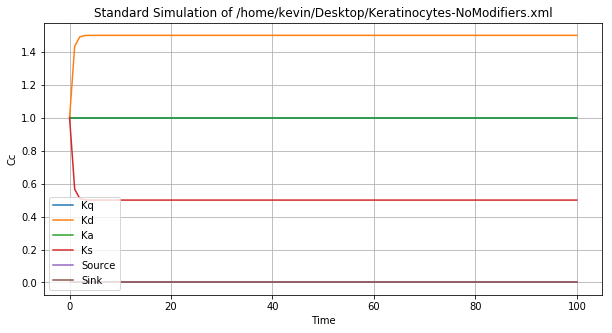

In [15]:
from matplotlib import pyplot
%matplotlib inline

pyplot.close()

pyplot.figure(figsize=(10, 5))

pltObjs = pyplot.plot(
    numpy.linspace(SciPyModel.SimulationData.TimeStart,
                   SciPyModel.SimulationData.TimeEnd,
                   SciPyModel.SimulationData.DataPoints),
    SciPyModel.SimulationData.Deterministic.Data)

pyplot.title('Standard Simulation of '+SciPyModel.MetaData.FilePath)
pyplot.ylabel('Cc')
pyplot.xlabel('Time')
pyplot.grid()

pyplot.legend( pltObjs, SciPyModel.Species.Names )

pyplot.show()

#### Final Notes

Once the desired simulations with the model are completed, the simulation data can be exported and the temporary files can be deleted.

In [16]:
import os
try:
    os.remove(TempName)
except OSError:
    print 'ERROR: Temporary file has already been deleted.'
else:
    print 'ERROR: Unknown error. Unable to remove '+TempName

ERROR: Unknown error. Unable to remove 1200PMApril172018.py
